In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform, Transform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import RandomPermutation

In [3]:
# 1. The Target Data: A Mixture of Gaussians
def get_data(n_samples):
    """Generates data from a 2-component 2D Gaussian Mixture Model."""
    X1 = torch.randn(n_samples // 2, 2) + torch.tensor([0, 5])
    X2 = torch.randn(n_samples // 2, 2) + torch.tensor([0, 3])
    return torch.cat([X1, X2], dim=0)

# 2. The Seed Encoder (Simple Transformer)
class SeedEncoder(nn.Module):
    """Encodes a discrete seed string into a continuous context vector."""
    def __init__(self, vocab_size, embedding_dim, context_dim, num_heads=4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=num_heads, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.fc_out = nn.Linear(embedding_dim, context_dim)

    def forward(self, seeds):
        embedded = self.embedding(seeds)
        encoded = self.transformer_encoder(embedded)
        pooled = encoded.mean(dim=1)
        context = self.fc_out(pooled)
        return context

# 3. The Generative Model (Conditional Normalizing Flow)
def create_flow(context_dim):
    """Creates a conditional Normalizing Flow model."""
    num_layers = 5
    base_dist = StandardNormal(shape=[2])
    transforms = []
    for _ in range(num_layers):
        transforms.append(RandomPermutation(features=2))
        transforms.append(
            MaskedAffineAutoregressiveTransform(
                features=2,
                hidden_features=64,
                context_features=context_dim
            )
        )
    transform = CompositeTransform(transforms)
    flow = Flow(transform, base_dist)
    return flow

# 3. NEW: Custom Real NVP Implementation
class RealNVPCouplingLayer(Transform):
    """
    Implements a single Real NVP coupling layer.
    The `mask` determines which half of the input is transformed and which is used for conditioning.
    """
    def __init__(self, features, context_features, hidden_features=32, mask=None):
        super().__init__()
        if mask is None:
            # By default, transform the second half
            self.mask = torch.zeros(features)
            self.mask[features // 2:] = 1
        else:
            self.mask = mask

        # Networks to compute scale (s) and translation (t)
        self.s_net = nn.Sequential(
            nn.Linear(features + context_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, features)
        )
        self.t_net = nn.Sequential(
            nn.Linear(features + context_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, features)
        )

    def forward(self, inputs, context=None):
        mask = self.mask.to(inputs.device)
        
        # Untouched part of the input
        x_identity = inputs * (1 - mask)
        
        # Part to be transformed
        x_transform = inputs * mask
        
        # Combine identity part with context for conditioning
        st_input = torch.cat([x_identity, context], dim=1)
        
        s = self.s_net(st_input) * mask
        t = self.t_net(st_input) * mask
        
        # Apply the transformation: y = x * exp(s) + t
        # We use tanh for stability, as suggested in some implementations
        s = torch.tanh(s)
        outputs = x_identity + x_transform * torch.exp(s) + t
        
        # The log-determinant of the Jacobian is simply the sum of s
        logabsdet = torch.sum(s, dim=1)
        
        return outputs, logabsdet

    def inverse(self, inputs, context=None):
        mask = self.mask.to(inputs.device)

        y_identity = inputs * (1 - mask)
        y_transform = inputs * mask
        
        st_input = torch.cat([y_identity, context], dim=1)
        
        s = self.s_net(st_input) * mask
        t = self.t_net(st_input) * mask
        
        s = torch.tanh(s)
        # Reverse the transformation: x = (y - t) * exp(-s)
        outputs = y_identity + (y_transform - t) * torch.exp(-s)
        
        logabsdet = -torch.sum(s, dim=1)
        
        return outputs, logabsdet

def create_real_nvp_flow(features, context_features):
    """Builds a flow from a stack of Real NVP coupling layers."""
    num_layers = 6
    transforms = []
    
    # Create alternating masks for the coupling layers
    mask0 = torch.zeros(features)
    mask0[features // 2:] = 1
    mask1 = 1 - mask0
    masks = [mask0, mask1] * (num_layers // 2)

    for i in range(num_layers):
        transforms.append(RealNVPCouplingLayer(
            features=features,
            context_features=context_features,
            mask=masks[i]
        ))
    
    # Using a CompositeTransform from nflows is convenient
    from nflows.transforms.base import CompositeTransform
    transform = CompositeTransform(transforms)
    base_dist = StandardNormal(shape=[features])
    flow = Flow(transform, base_dist)
    return flow

# 4. The Training Loop (for fixed seeds with DataLoader)
def train(encoder, flow, dataloader, config, device):
    if config['use_seeds']:
        print("Starting training in CONDITIONAL mode (with seeds)...")
        params = list(encoder.parameters()) + list(flow.parameters())
    else:
        print("Starting training in UNCONDITIONAL mode (seeds disabled)...")
        params = flow.parameters() # Only train the flow

    optimizer = optim.Adam(params, lr=config['learning_rate'])
    
    for epoch in range(config['num_epochs']):
        for batch in dataloader:
            optimizer.zero_grad()
            
            if config['use_seeds']:
                batch_data, batch_seeds = batch
                batch_data = batch_data.to(device)
                batch_seeds = batch_seeds.to(device)
                context = encoder(batch_seeds)
            else: # <-- MODIFIED LOGIC
                batch_data = batch[0].to(device)
                # Create a constant zero vector for the context
                context = torch.zeros(batch_data.shape[0], config['context_dim'], device=device)

            loss = -flow.log_prob(inputs=batch_data, context=context).mean()
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 2 == 0:
            print(f"Epoch {epoch+1}/{config['num_epochs']}, Loss: {loss.item():.4f}")
    
    print("Training finished.")


# 5. Visualization of Generated Samples
def evaluate_and_plot(encoder, flow, original_data, config, device):
    encoder.eval()
    flow.eval()
    
    with torch.no_grad():
        if config['use_seeds']:
            # Use two different seeds for comparison
            seed1 = torch.tensor([[0, 1, 2, 3, 4]], device=device).repeat(1000, 1)
            seed2 = torch.tensor([[5, 6, 7, 8, 9]], device=device).repeat(1000, 1)
            context1 = encoder(seed1)
            context2 = encoder(seed2)
            title1 = 'Samples Conditioned on Seed Type 1'
            title2 = 'Samples Conditioned on Seed Type 2'
        else: # <-- MODIFIED LOGIC
            # Use the same zero context for both "samples"
            context1 = torch.zeros(1000, config['context_dim'], device=device)
            context2 = context1 # They are identical
            title1 = 'Unconditional Samples'
            title2 = 'Unconditional Samples (Same Dist.)'

        samples1 = flow.sample(1000, context=context1)
        samples2 = flow.sample(1000, context=context2)

    original_data = original_data.cpu()
    samples1 = samples1.cpu()
    samples2 = samples2.cpu()

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    axes[0].scatter(original_data[:, 0], original_data[:, 1], alpha=0.5)
    axes[0].set_title('Original Target Distribution')
    axes[1].scatter(samples1[:, 0], samples1[:, 1], alpha=0.5, color='green')
    axes[1].set_title(title1)
    axes[2].scatter(samples2[:, 0], samples2[:, 1], alpha=0.5, color='red')
    axes[2].set_title(title2)
    for ax in axes: ax.set_aspect('equal', adjustable='box')
    plt.show()

# 6. Visualization of Seed Clustering
def visualize_seed_embeddings(encoder, config, device):
    """
    Generates seeds for each known component, gets their embeddings,
    and visualizes them using t-SNE.
    """
    print("Visualizing seed embeddings...")
    encoder.eval()
    
    num_seeds_per_component = 500
    
    # Seeds associated with Component 1 (e.g., using lower half of vocab)
    seeds1 = torch.randint(0, config['vocab_size'] // 2, 
                           (num_seeds_per_component, config['seed_length']), 
                           device=device)
    
    # Seeds associated with Component 2 (e.g., using upper half of vocab)
    seeds2 = torch.randint(config['vocab_size'] // 2, config['vocab_size'],
                           (num_seeds_per_component, config['seed_length']),
                           device=device)

    all_seeds = torch.cat([seeds1, seeds2], dim=0)
    labels = torch.cat([
        torch.zeros(num_seeds_per_component),
        torch.ones(num_seeds_per_component)
    ]).numpy()

    with torch.no_grad():
        embeddings = encoder(all_seeds).cpu().numpy()

    print("Running t-SNE... (this may take a moment)")
    tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', n_iter=1000, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.title('t-SNE Visualization of Seed Embeddings')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(handles=scatter.legend_elements()[0], labels=['Component 1 Seeds', 'Component 2 Seeds'])
    plt.grid(True)
    plt.show()

In [7]:
if __name__ == '__main__':
    config = {
        'use_seeds': False, # <-- NEW: Master toggle for conditioning
        'num_samples': 15000,
        'vocab_size': 10,
        'seed_length': 5,
        'embedding_dim': 64,
        'context_dim': 32,
        'num_epochs': 2000,
        'batch_size': 256,
        'learning_rate': 3e-3,
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data = get_data(config['num_samples'])
    
    if config['use_seeds']:
        # Pair data with fixed seeds
        fixed_seeds = torch.randint(0, config['vocab_size'], (config['num_samples'], config['seed_length']))
        dataset = TensorDataset(data, fixed_seeds)
    else:
        # Just use the data, no seeds needed
        dataset = TensorDataset(data)

    dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)
    
    encoder = SeedEncoder(
        vocab_size=config['vocab_size'],
        embedding_dim=config['embedding_dim'],
        context_dim=config['context_dim']
    ).to(device)
    
    flow = create_real_nvp_flow(features=2, context_features=config['context_dim']).to(device)
    
    train(encoder, flow, dataloader, config, device)

Starting training in UNCONDITIONAL mode (seeds disabled)...
Epoch 2/2000, Loss: 3.1421
Epoch 4/2000, Loss: 3.1092
Epoch 6/2000, Loss: 3.2316
Epoch 8/2000, Loss: 3.1053
Epoch 10/2000, Loss: 3.1397
Epoch 12/2000, Loss: 3.1753
Epoch 14/2000, Loss: 3.2138
Epoch 16/2000, Loss: 3.0709
Epoch 18/2000, Loss: 3.1328
Epoch 20/2000, Loss: 3.2138
Epoch 22/2000, Loss: 3.0922
Epoch 24/2000, Loss: 3.1431
Epoch 26/2000, Loss: 3.1483
Epoch 28/2000, Loss: 3.1260
Epoch 30/2000, Loss: 3.2204
Epoch 32/2000, Loss: 3.2116
Epoch 34/2000, Loss: 3.2575
Epoch 36/2000, Loss: 3.1091
Epoch 38/2000, Loss: 3.2657
Epoch 40/2000, Loss: 3.2351
Epoch 42/2000, Loss: 3.2803


KeyboardInterrupt: 

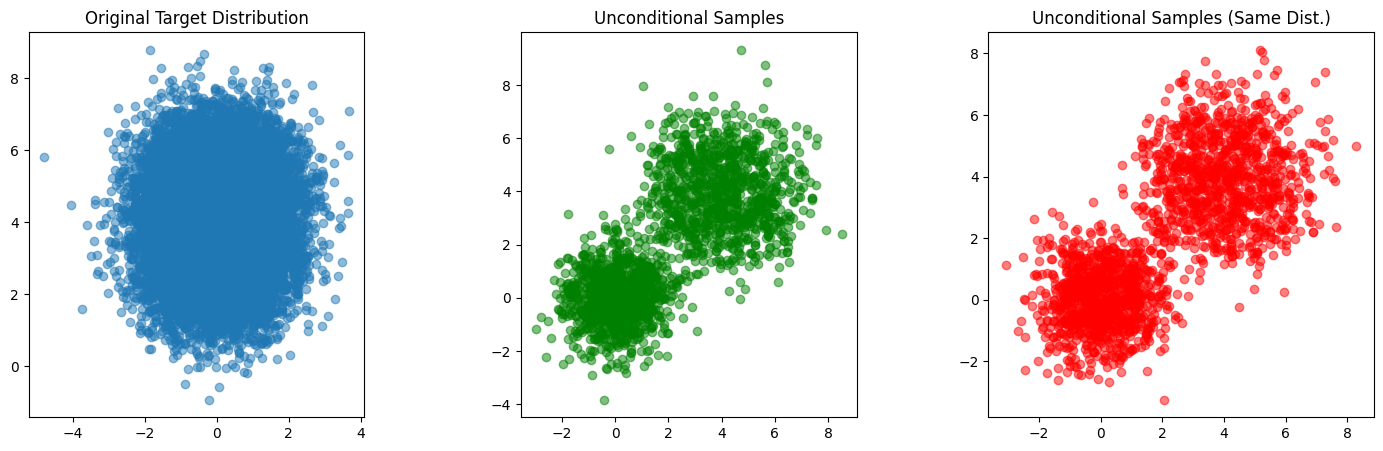

In [8]:
# Evaluate and plot result
evaluate_and_plot(encoder, flow, data, config, device) # <-- MODIFIED